In [1]:
from google.colab import files
files.upload()

Saving SGDW.py to SGDW.py
Saving RAdam.py to RAdam.py
Saving OneCycle.py to OneCycle.py
Saving Lookahead.py to Lookahead.py
Saving CLR.py to CLR.py
Saving AdamW.py to AdamW.py


{'AdamW.py': b'import math\nimport torch\nfrom torch.optim.optimizer import Optimizer\n\nclass AdamW(Optimizer):\n    r"""Implements Adam algorithm with decoupled weight decay.\n\n    It has been proposed in `DECOUPLED WEIGHT DECAY REGULARIZATION`_.\n    Below is modification of adam code from pytorch repository(https://github.com/pytorch/pytorch)\n\n    Arguments:\n        params (iterable): iterable of parameters to optimize or dicts defining\n            parameter groups\n        lr (float, optional): learning rate (default: 1e-3)\n        betas (Tuple[float, float], optional): coefficients used for computing\n            running averages of gradient and its square (default: (0.9, 0.999))\n        eps (float, optional): term added to the denominator to improve\n            numerical stability (default: 1e-8)\n        weight_decay (float, optional): weight decay (default: 0)\n        amsgrad (boolean, optional): whether to use the AMSGrad variant of this\n            algorithm from t

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

In [0]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import CIFAR10
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import math
import tqdm as tqdm
from Lookahead import Lookahead
from AdamW import AdamW
from RAdam import RAdam

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
np.random.seed(11)

# Load Dataset

In [0]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

In [0]:
normalize = transforms.Normalize(mean=mean, std=std)
train_transforms = transforms.Compose([
                    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    normalize
                ])
valid_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    normalize
                ])

In [8]:
trainset = CIFAR10('./data', train=True, download=True, transform=train_transforms)
testset = CIFAR10('./data', train=False, download=True, transform=valid_transforms)

0it [00:00, ?it/s]

100%|█████████▉| 169959424/170498071 [00:11<00:00, 35218660.80it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
bs=128
epochs=90
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
train_loader = DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=4)
test_loader = DataLoader(testset, batch_size=bs, shuffle=False, num_workers=4)

# Plot Images

In [0]:
# Plot few of the images
# This can be used to print predictions too
def plot_img(preds=None, is_pred=False):        
    fig = plt.figure(figsize=(8,8))
    columns = 4
    rows = 5

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        
        if is_pred:
            img_xy = np.random.randint(len(testset));
            img = testset[img_xy][0].numpy()
            #img = img * std + mean
        else:
            img_xy = np.random.randint(len(trainset));
            img = trainset[img_xy][0].numpy()
            #img = img * std + mean
        
        if is_pred:
            plt.title(classes[int(preds[img_xy])] + "/" + classes[testset[img_xy][1]])
        else:
            plt.title(classes[trainset[img_xy][1]])
        plt.axis('off')
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img , (1,2,0)))
    plt.show()

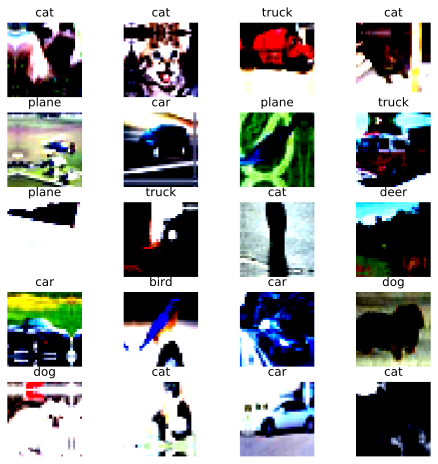

In [12]:
plot_img()

# save and load checkpoint

In [0]:
def save_checkpoint(model, is_best, filename='data/checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [0]:
def load_checkpoint(model, filename = 'data/checkpoint.pth.tar'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()):
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

# Global variables

In [0]:
train_loss = 0.0
test_loss = 0.0
best_acc = 0.0
trn_losses = []
trn_accs = []
val_losses = []
val_accs = []

In [0]:
total = 0
correct = 0

# Helper functions

In [0]:
def accuracy(output, target, is_test=False):
    global total
    global correct
    batch_size = target.size(0)
    total += batch_size  
    _, pred = output.max(dim=1)
    if is_test:
        preds.extend(pred)
    correct += torch.sum(pred == target.data)
    return (correct.float() / total) * 100

In [0]:
def reset():
    global total, correct
    global train_loss, test_loss, best_acc
    global trn_accs, trn_losses, val_accs, val_losses
    total, correct = 0, 0
    train_loss, test_loss, best_acc = 0.0, 0.0, 0.0
    trn_losses, trn_accs, val_accs, val_losses = [], [], [], []

In [0]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.precs =[]
        self.its = []
        
    def append(self, loss, prec, it):
        self.losses.append(loss)
        self.precs.append(prec)
        self.its.append(it)

# Train and Test

In [0]:
def train(epoch=0, model=None, optimizer=None):
    model.train()
    global best_acc
    global trn_accs, trn_losses
    is_improving = True
    counter = 0
    running_loss = 0.
    avg_beta = 0.98

    for i, (input, target) in enumerate(train_loader):
        bt_start = time.time()
        input, target = input.to(device), target.to(device)
        var_ip, var_tg = Variable(input), Variable(target)
                                    
        output = model(var_ip)
        loss = criterion(output, var_tg)
            
        running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        
        trn_losses.append(smoothed_loss)
            
        # measure accuracy and record loss
        prec = accuracy(output.data, target)
        trn_accs.append(prec)

        train_stats.append(smoothed_loss, prec, time.time()-bt_start)
        if prec > best_acc :
            best_acc = prec
            save_checkpoint(model, True)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [0]:
def test(model=None):
    with torch.no_grad():
        model.eval()
        global val_accs, val_losses
        running_loss = 0.
        avg_beta = 0.98
        for i, (input, target) in enumerate(test_loader):
            bt_start = time.time()
            input, target = input.to(device), target.to(device)
            var_ip, var_tg = Variable(input), Variable(target)
            output = model(var_ip)
            loss = criterion(output, var_tg)
        
            running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
            smoothed_loss = running_loss / (1 - avg_beta**(i+1))

            # measure accuracy and record loss
            prec = accuracy(output.data, target, is_test=True)
            test_stats.append(loss.item(), prec, time.time()-bt_start)
        
            val_losses.append(smoothed_loss)
            val_accs.append(prec)

In [0]:
def fit(model=None, optimizer=None, sched=None):
    print("Epoch\tTrn_loss\tVal_loss\tTrn_acc\t\tVal_acc")
    for j in range(epochs):
        train(j, model, optimizer)
        test(model)
        if sched:
          sched.step(j)
        print("{}\t{:06.8f}\t{:06.8f}\t{:06.8f}\t{:06.8f}"
              .format(j+1, trn_losses[-1], val_losses[-1], trn_accs[-1], val_accs[-1]))

# Model

In [23]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth

  0%|          | 0.00/44.7M [00:00<?, ?B/s]
  3%|▎         | 1.19M/44.7M [00:00<00:04, 11.3MB/s]
  4%|▍         | 1.81M/44.7M [00:00<00:04, 9.23MB/s]
 10%|▉         | 4.44M/44.7M [00:00<00:03, 11.5MB/s]
 15%|█▌        | 6.78M/44.7M [00:00<00:02, 13.7MB/s]
 20%|█▉        | 8.88M/44.7M [00:00<00:02, 15.0MB/s]
 26%|██▌       | 11.6M/44.7M [00:00<00:02, 17.3MB/s]
 30%|███       | 13.4M/44.7M [00:00<00:01, 17.0MB/s]
 36%|███▌      | 16.1M/44.7M [00:00<00:01, 19.1MB/s]
 40%|████      | 18.1M/44.7M [00:00<00:01, 18.9MB/s]
 45%|████▍     | 20.0M/44.7M [00:01<00:01, 14.9MB/s]
 50%|█████     | 22.4M/44.7M [00:01<00:01, 17.0MB/s]
 56%|█████▌    | 24.8M/44.7M [00:01<00:01, 18.7MB/s]
 60%|██████    | 26.8M/44.7M [00:01<00:01, 17.7MB/s]
 64%|██████▍   | 28.7M/44.7M [00:01<00:01, 13.6MB/s]
 68%|██████▊   | 30.4M/44.7M [00:01<00:01, 14.5MB/s]
 72%|███████▏  | 32.0M/44.7M [0

In [0]:
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=10, bias=True)

In [25]:
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in model.parameters():
  param.requires_grad = True

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-4, momentum=0.9)

In [0]:
sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.2)

In [0]:
save_checkpoint(model, True, filename='before_sgd_resnet18.pth.tar')

In [0]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
reset()

In [0]:
fit(model, optimizer, sched)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	0.78144722	0.69162591	65.81599426	67.58833313
2	0.65414955	0.71061546	71.79454803	72.21582794
3	0.57582089	0.56978001	74.41706085	74.75389099
4	0.52894990	0.55394383	76.24652100	76.46125031
5	0.49460261	0.54243252	77.55241394	77.68333435
6	0.46320435	0.49345893	78.56885529	78.70999908
7	0.43627403	0.50981798	79.44195557	79.53546906
8	0.41583075	0.50034805	80.20213318	80.27354431
9	0.41100989	0.49854687	80.81623077	80.86592865
10	0.37449969	0.48470622	81.36474609	81.41683197
11	0.37572437	0.50206496	81.88569641	81.90985107
12	0.37215963	0.46065421	82.31535339	82.34542084
13	0.35110608	0.46568915	82.71428680	82.73769379
14	0.35841818	0.48984524	83.07758331	83.09571075
15	0.32141879	0.45238774	83.43809509	83.46067047
16	0.30553973	0.48818813	83.76936340	83.77687073
17	0.29430746	0.45426958	84.07563782	84.09353638
18	0.28268132	0.46222674	84.37775421	84.38907623
19	0.28569646	0.47280294	84.65256500	84.66008759
20	0.28531800	0.44965189	84.91025543	

In [0]:
save_checkpoint(model, True, 'sgd_resnet18_9333.pth.tar')

In [0]:
ep_sgd_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_sgd_losses.append(train_stats.losses[i])
        
ep_sgd_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_sgd_lossesv.append(test_stats.losses[i])

In [0]:
ep_sgd_accs = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_sgd_accs.append(train_stats.precs[i])
        
ep_sgd_accsv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_sgd_accsv.append(test_stats.precs[i])

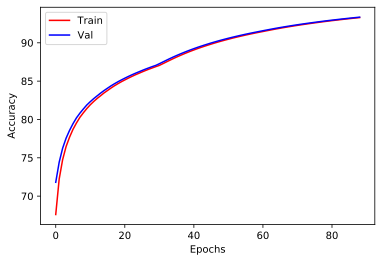

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(ep_sgd_accs, 'r', label='Train')
plt.plot(ep_sgd_accsv, 'b', label='Val')
plt.legend()
plt.savefig('sgd_resnet18_9333_acc.jpg')

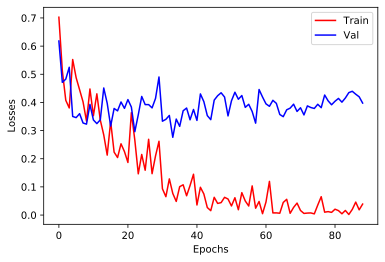

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(ep_sgd_losses, 'r', label='Train')
plt.plot(ep_sgd_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('sgd_resnet18_9333_loss.jpg')

In [0]:
from google.colab import files
files.download('./sgd_resnet18_9333.pth.tar')
files.download('./sgd_resnet18_9333_acc.jpg')
files.download('./sgd_resnet18_9333_loss.jpg')

# ADAMW

In [0]:
load_checkpoint(model, filename='before_sgd_resnet18.pth.tar')

In [0]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
reset()

In [0]:
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)

In [0]:
fit(model, optimizer, sched)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	0.86885929	0.74737408	60.95799637	63.12666702
2	0.71511656	0.62655072	68.41181183	69.23583221
3	0.60800268	0.55988485	72.01058960	72.50555420
4	0.53849239	0.53487780	74.34696198	74.66541290
5	0.50491721	0.50635128	76.07897186	76.29433441
6	0.46538620	0.49752907	77.41943359	77.57805634
7	0.42562772	0.48834966	78.50219727	78.62023926
8	0.39749796	0.50960226	79.41277313	79.49604034
9	0.37638987	0.48983808	80.20792389	80.28277588
10	0.35278105	0.48467824	80.92592621	80.97983551
11	0.34237109	0.47242582	81.56430817	81.61075592
12	0.32274716	0.46722133	82.13605499	82.17694855
13	0.29914275	0.47568831	82.68207550	82.71371460
14	0.27742496	0.49464957	83.17023468	83.19213867
15	0.26727694	0.47494474	83.61775970	83.63311005
16	0.26196750	0.49721024	84.03568268	84.04364777
17	0.25785484	0.47724417	84.41980743	84.42706299
18	0.23974537	0.49774931	84.78849792	84.78731537
19	0.21883746	0.48102030	85.12876129	85.13342285
20	0.21856885	0.50451101	85.46100616	

In [0]:
save_checkpoint(model, True, 'adamw_resnet18_9278.pth.tar')

In [0]:
ep_adamw_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_adamw_losses.append(train_stats.losses[i])
        
ep_adamw_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_adamw_lossesv.append(test_stats.losses[i])

In [0]:
ep_adamw_accs = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_adamw_accs.append(train_stats.precs[i])
        
ep_adamw_accsv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_adamw_accsv.append(test_stats.precs[i])

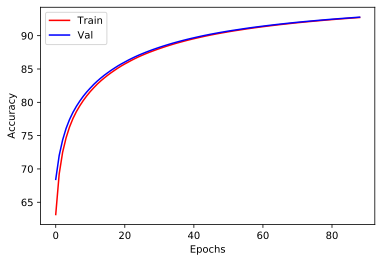

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(ep_adamw_accs, 'r', label='Train')
plt.plot(ep_adamw_accsv, 'b', label='Val')
plt.legend()
plt.savefig('adamw_resnet18_9278_acc.jpg')

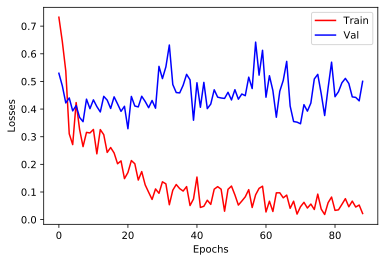

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(ep_adamw_losses, 'r', label='Train')
plt.plot(ep_adamw_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('adamw_resnet18_9278_loss.jpg')

In [0]:
from google.colab import files
files.download('./adamw_resnet18_9278.pth.tar')
files.download('./adamw_resnet18_9278_acc.jpg')
files.download('./adamw_resnet18_9278_loss.jpg')

# Lookahead with SGD

In [0]:
load_checkpoint(model, filename='before_sgd_resnet18.pth.tar')

In [0]:
reset()

In [0]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
optims = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)

In [0]:
sched_la = torch.optim.lr_scheduler.StepLR(optims, step_size=30, gamma=0.2)

In [0]:
la_optim = Lookahead(optims, alpha=0.5, k=10)

In [0]:
fit(model, la_optim, sched_la)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	0.78479352	0.67165694	65.26199341	67.26000214
2	0.65817790	0.57374612	71.45182037	72.19833374
3	0.58128622	0.55141889	74.37470245	74.75722504
4	0.52962197	0.51966717	76.22391510	76.48666382
5	0.47890591	0.52298214	77.58689880	77.75066376
6	0.46181699	0.53919718	78.61714172	78.70610809
7	0.42780571	0.53746683	79.46121979	79.52833557
8	0.41239739	0.51101025	80.19277191	80.26103973
9	0.37363482	0.53151295	80.84622955	80.88333130
10	0.36207809	0.44956800	81.41728973	81.47850037
11	0.35154171	0.45184920	81.96661377	82.02075958
12	0.34081617	0.46462456	82.44577026	82.48000336
13	0.34036227	0.44493051	82.88973236	82.91999817
14	0.32164129	0.45059167	83.30180359	83.32344818
15	0.31193304	0.46006976	83.67045593	83.68900299
16	0.29992676	0.51223011	84.02136230	84.02281189
17	0.28413972	0.47487951	84.33504486	84.33735657
18	0.26384980	0.48605247	84.63252258	84.63741302
19	0.25498864	0.52070410	84.91609955	84.90903473
20	0.26259867	0.45545643	85.17688751	

In [0]:
save_checkpoint(model, True, 'lookahead_sgd_resnet18_9340.pth.tar')

In [0]:
ep_lookahead_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_losses.append(train_stats.losses[i])
        
ep_lookahead_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_lossesv.append(test_stats.losses[i])

In [0]:
ep_lookahead_accs = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_accs.append(train_stats.precs[i])
        
ep_lookahead_accsv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_accsv.append(test_stats.precs[i])

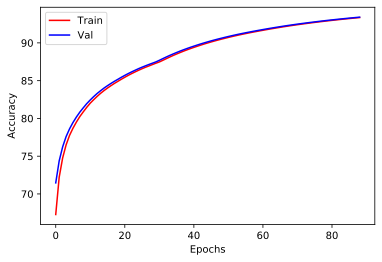

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(ep_lookahead_accs, 'r', label='Train')
plt.plot(ep_lookahead_accsv, 'b', label='Val')
plt.legend()
plt.savefig('lookahead_sgd_resnet18_9340_acc.jpg')

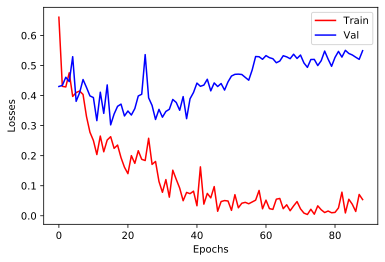

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(ep_lookahead_losses, 'r', label='Train')
plt.plot(ep_lookahead_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('lookahead_sgd_resnet18_9340_loss.jpg')

In [0]:
from google.colab import files
files.download('./lookahead_sgd_resnet18_9340.pth.tar')
files.download('./lookahead_sgd_resnet18_9340_acc.jpg')
files.download('./lookahead_sgd_resnet18_9340_loss.jpg')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 43182, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

# RAdam

In [0]:
load_checkpoint(model, filename='before_sgd_resnet18.pth.tar')

In [0]:
reset()

In [0]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
optimizer = RAdam( model.parameters(), lr=1e-4, weight_decay=1e-1)

In [0]:
sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.2)

In [0]:
fit(model, optimizer, sched)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	1.18530725	1.05326346	41.71199799	45.27833557
2	0.84762171	0.78671370	55.37272644	56.84083176
3	0.73144797	0.65561085	61.93588257	62.82055283
4	0.64784921	0.60311341	65.96218109	66.51333618
5	0.57844064	0.57227305	68.77137756	69.16300201
6	0.53403480	0.53500383	70.91000366	71.20666504
7	0.48211888	0.50810422	72.64511871	72.87571716
8	0.44835984	0.50016035	74.09233856	74.28416443
9	0.41966877	0.49424403	75.32736206	75.48258972
10	0.40778929	0.49177240	76.39678192	76.51966858
11	0.37237922	0.48817772	77.32800293	77.42515564
12	0.34810258	0.49522225	78.15563202	78.23972321
13	0.33294963	0.48063611	78.90350342	78.97192383
14	0.30538665	0.48806705	79.59843445	79.66261292
15	0.31243235	0.46457527	80.23202515	80.28844452
16	0.28032078	0.47656395	80.82125854	80.86062622
17	0.26907302	0.48152149	81.34742737	81.38284302
18	0.25399353	0.49785336	81.84186554	81.87000275
19	0.24158442	0.48593774	82.29973602	82.32736206
20	0.24420652	0.49364878	82.73580170	

In [0]:
save_checkpoint(model, True, 'radam_resnet18_9303.pth.tar')

In [0]:
ep_lookahead_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_losses.append(train_stats.losses[i])
        
ep_lookahead_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_lossesv.append(test_stats.losses[i])

In [0]:
ep_lookahead_accs = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_accs.append(train_stats.precs[i])
        
ep_lookahead_accsv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_accsv.append(test_stats.precs[i])

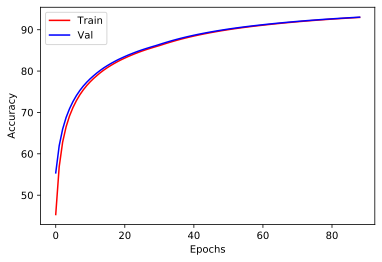

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(ep_lookahead_accs, 'r', label='Train')
plt.plot(ep_lookahead_accsv, 'b', label='Val')
plt.legend()
plt.savefig('radam_resnet18_9303_acc.jpg')

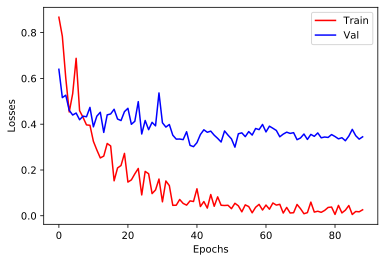

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(ep_lookahead_losses, 'r', label='Train')
plt.plot(ep_lookahead_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('radam_resnet18_9303_loss.jpg')

In [0]:
from google.colab import files
files.download('./radam_resnet18_9303.pth.tar')
files.download('./radam_resnet18_9303_acc.jpg')
files.download('./radam_resnet18_9303_loss.jpg')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 46536, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

# Lookahead with radam

In [0]:
load_checkpoint(model, filename='before_sgd_resnet18.pth.tar')

In [0]:
reset()

In [0]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
optim = RAdam( model.parameters(), lr=1e-3, weight_decay=1e-4)

In [0]:
sched = torch.optim.lr_scheduler.StepLR(optim, step_size=30, gamma=0.2)

In [0]:
optimizer = Lookahead(optim, alpha=0.5, k=10)

In [37]:
fit(model, optimizer, sched)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	0.84583154	0.73178216	58.65999985	61.38833237
2	0.69071751	0.61502318	67.61090851	68.56082916
3	0.61432442	0.58344361	71.45764923	71.96111298
4	0.55044891	0.56880743	73.80130768	74.10124969
5	0.52851939	0.58787560	75.38758850	75.55400085
6	0.51058717	0.63163685	76.59285736	76.66361237
7	0.47908891	0.55923976	77.52000427	77.63571167
8	0.46200907	0.55604542	78.35383606	78.41625214
9	0.43321949	0.56300320	79.05509186	79.11425781
10	0.41723501	0.42355409	79.69135284	79.79199982
11	0.41177784	0.43361225	80.30723572	80.38197327
12	0.38238970	0.47381668	80.84745789	80.89416504
13	0.38201587	0.45383021	81.30129242	81.34756470
14	0.35697211	0.47005762	81.73987579	81.77285004
15	0.35281760	0.48937094	82.13303375	82.15711212
16	0.33853201	0.57281240	82.49789429	82.49343872
17	0.32870081	0.49624227	82.82604218	82.84352875
18	0.31817437	0.50240642	83.14177704	83.15074158
19	0.31168358	0.54314920	83.44114685	83.43403625
20	0.29778440	0.42684041	83.71403503	

In [0]:
save_checkpoint(model, True, 'radam_lookahead_resnet18_9314.pth.tar')

In [0]:
ep_lookahead_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_losses.append(train_stats.losses[i])
        
ep_lookahead_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_lossesv.append(test_stats.losses[i])

In [0]:
ep_lookahead_accs = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_accs.append(train_stats.precs[i])
        
ep_lookahead_accsv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_accsv.append(test_stats.precs[i])

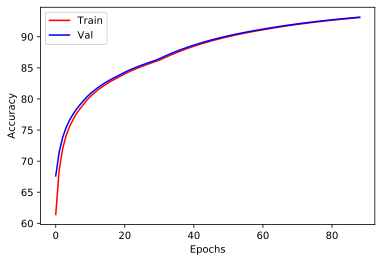

In [41]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(ep_lookahead_accs, 'r', label='Train')
plt.plot(ep_lookahead_accsv, 'b', label='Val')
plt.legend()
plt.savefig('radam_lookahead_resnet18_9314_acc.jpg')

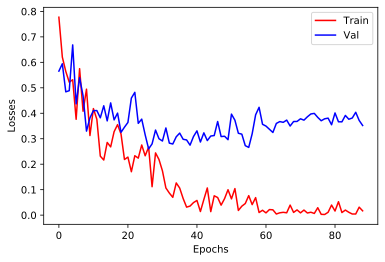

In [42]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(ep_lookahead_losses, 'r', label='Train')
plt.plot(ep_lookahead_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('radam_lookahead_resnet18_9314_loss.jpg')

In [0]:
from google.colab import files
files.download('./radam_lookahead_resnet18_9314.pth.tar')
files.download('./radam_lookahead_resnet18_9314_acc.jpg')
files.download('./radam_lookahead_resnet18_9314_loss.jpg')